## Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras_self_attention
!pip install keras_layer_normalization
!pip install pyvi

  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=ef1eb36b97fcbd8ddfa4617b736a7afac8c3b7b44c05b32f727f6c3e3e85e2e2
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention
  Preparing metadata (setup.py) ... done
  Created wheel for keras_layer_normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4654 sha256=a0ae459af9d1fad11e1bd7ffb125112fd1ab2542df7561d86e984e913c3bb46a
  Stored in directory: /root/.cache/pip/wheels/ed/3a/4b/21db23c0cc56c4b219616e181f258eb7c57d36cc5d056fae9a
Successfully built keras_layer_normalization
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from pyvi import ViTokenizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import random
import pickle
import json
from collections import Counter
from sklearn.model_selection import train_test_split
tf.keras.utils.plot_model
from sklearn.metrics import classification_report

In [4]:
ROOT_PATH = '/content/drive/My Drive/DBM/'

## Load and process data

In [5]:
train = pd.read_csv(ROOT_PATH + 'train1.csv', encoding='utf-8')
print(train.shape)
train.head()

(22070, 2)


,content,ground
0,Trong hình in chữ trắng nhận hàng thì lại là ...,0
1,Chất liệu: Mềm nên mua nha.Màu sắc: Đúng với h...,1
2,Màu sắc: đúng với mô tảChất liệu: vải dùmặc và...,0
3,Hàng hok như hình cho lắm,0
4,Xịn lắm nha mọi người ơi với cái giá này thì k...,1


In [6]:
test = pd.read_csv(ROOT_PATH + 'test1.csv', encoding='utf-8')
print(test.shape)
test.head()

(2453, 2)


,content,ground
0,"Giao hàng nhanh chóng, đóng gói cẩn thận, hàng...",1
1,"Được biết shop qua group Cháy túi vì Shopee, t...",1
2,Chán thất vọng,0
3,"Màu sắc: NâuQuần đẹp, rộng rãi, mình mua tặng ...",1
4,Shop soạn hàng rất ẩu. \nMình đặt lần đầu bị s...,0


In [7]:
import pandas as pd
import re
from pyvi import ViTokenizer

# Hàm để loại bỏ URL
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

# Hàm để loại bỏ emoji
def remove_emojis(text):
    emoji_pattern = re.compile(
        "["u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Hàm để đọc file chứa các từ viết tắt và từ thay thế vào dictionary
def load_abbreviations(file_path):
    abbreviations = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            short, full = line.strip().split(',')
            abbreviations[short] = full
    return abbreviations

# Hàm để thay thế các từ viết tắt trong văn bản
def replace_abbreviations(text, abbreviations):
    words = text.split()
    replaced_words = [abbreviations.get(word, word) for word in words]
    return ' '.join(replaced_words)

# Hàm để chuẩn hóa văn bản
def text_normalize(df, abbreviations_file, tokenize=False):
    abbreviations = load_abbreviations(abbreviations_file)

    # Convert text to lowercase
    df['content'] = df['content'].astype(str).str.lower()
    # Remove numbers and words with numbers
    df['content'] = df['content'].str.replace('\w*\d\w*', ' ', regex=True)
    # Remove URLs
    df['content'] = df['content'].apply(remove_urls)
    # Remove punctuation
    df['content'] = df['content'].str.replace('[^\w\s]', ' ', regex=True)
    # Remove emojis
    df['content'] = df['content'].apply(remove_emojis)
    # Replace abbreviations
    df['content'] = df['content'].apply(lambda x: replace_abbreviations(x, abbreviations))
    # Remove whitespaces
    df['content'] = df['content'].str.split().apply(lambda x: ' '.join(word for word in x))
    # Tokenize
    if tokenize:
        df['content'] = df['content'].apply(lambda x: ViTokenizer.tokenize(x))
    return df

abbreviations_file = 'abbreviate.txt'



In [ ]:
def text_normalize(df, tokenize=False):
    # Convert text to lowercase
    df['content'] = df['content'].str.lower()
    # Remove numbers and words with numbers
    df['content'] = df['content'].str.replace('\w*\d\w*', ' ')
    # Remove punctuation
    df['content'] = df['content'].str.replace('[^\w\s]', ' ')
    # Remove whitespaces
    # Handle potential float values by converting them to strings
    df['content'] = df['content'].apply(lambda x: ' '.join(str(word) for word in x.split()) if isinstance(x, str) else '')
    # Tokenize
    if tokenize:
        df['content'] = df['content'].apply(lambda x : ViTokenizer.tokenize(x)) # Make sure ViTokenizer is defined elsewhere

In [8]:
text_normalize(train)
text_normalize(test)
test.tail()

TypeError: text_normalize() missing 1 required positional argument: 'abbreviations_file'

In [11]:
# In 'ipython-input-8-c89579f4e03c'
abbreviations_file = '/content/drive/MyDrive/DBM/abbreviate.txt' # Make sure this file exists
text_normalize(train, abbreviations_file) # Pass the abbreviations file to the function
text_normalize(test, abbreviations_file)
test.tail()

,content,ground
2448,vải bình thường hơi mỏng,0
2449,áo màu đen này chất xấu nóng và mỏng hơn so vớ...,0
2450,shop giao đúng hàng đúng mẫu vải đẹp dày dặn đ...,1
2451,màu sắc ddepjđúng với mô tả đúngchất liệu khôn...,1
2452,vải quá xấu,0


In [12]:
plt.figure(figsize = (5, 4))
sns.countplot(train.ground)
plt.show()

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize = (5, 4))
sns.countplot(test.ground)
plt.show()

## Word Embedding

In [14]:
# load the whole embedding into memory
embeddings_index = dict()
f = open(ROOT_PATH + 'cc.vi.300.vec', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 2000000 word vectors.


In [15]:
def make_padded_docs(texts, max_length, tokenizer=None):
    if tokenizer == None:
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(texts)
    vocab_size = len(tokenizer.word_index) + 1
    # integer encode the documents
    encoded_docs = tokenizer.texts_to_sequences(texts)
    # print(encoded_docs)
    # pad documents to a max length of 4 words
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post', truncating='post')
    print(f'padded_docs shape: {padded_docs.shape}')

    return padded_docs, vocab_size, tokenizer

In [16]:
def make_weight_matrix(embeddings_index, vocab_size, dim, tokenizer):
    # create a weight matrix for words in training docs
    embedding_matrix = np.zeros((vocab_size, dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    print(f'embedding_matrix shape: {embedding_matrix.shape}')

    return embedding_matrix

In [17]:
labels = np.array(train.ground)
Counter(labels)

Counter({0: 10778, 1: 11292})

In [18]:
X_train, X_val, y_train, y_val = train_test_split(train.content.tolist(), labels, test_size=0.1)

In [19]:
max_length = 256
dim = 300
# prepare tokenizer
t = None
X_train, vocab_size, t = make_padded_docs(X_train,
                                       max_length,
                                       t)
X_val, _, _ = make_padded_docs(X_val,
                            max_length,
                            t)
embedding_matrix = make_weight_matrix(embeddings_index,
                                            vocab_size,
                                            dim,
                                            t)

padded_docs shape: (19863, 256)
padded_docs shape: (2207, 256)
embedding_matrix shape: (10724, 300)


## RNN model

In [20]:
from keras.models import Model
from keras.layers import \
    Dense, Embedding, Input, \
    GRU, LSTM, Bidirectional, \
    GlobalMaxPool1D, GlobalAveragePooling1D, Dropout, \
    Lambda, Concatenate, TimeDistributed  # Removed CuDNNGRU and CuDNNLSTM
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
from keras.activations import softmax
from keras_layer_normalization import LayerNormalization
from keras.regularizers import l2

In [21]:
alpha = 0.01

In [22]:
inp = Input(shape = (max_length, ))
x = Embedding(input_dim = vocab_size,
              output_dim = dim,
              weights = [embedding_matrix],
              trainable = True)(inp)

x = Bidirectional(GRU(256,
                           kernel_regularizer=l2(alpha),
                           # bias_regularizer=l2(alpha),
                           return_sequences = True))(x)
x = Dropout(0.5)(x)
x = Bidirectional(GRU(256,
                           kernel_regularizer=l2(alpha),
                           # bias_regularizer=l2(alpha),
                           return_sequences = True))(x)
x = Dropout(0.5)(x)

max_pool = GlobalMaxPool1D()(x)
avg_pool = GlobalAveragePooling1D()(x)
last = Lambda(lambda x: x[:, 0, :])(x)
concat_pool = Concatenate(axis = -1)([last, max_pool, avg_pool])

op = Dense(64,
           kernel_regularizer=l2(alpha),
           # bias_regularizer=l2(alpha),
           activation = "relu")(concat_pool)
# op = Dropout(0.8)(op)
op = Dense(1, activation = "sigmoid")(op)

RNN = Model(inputs = inp, outputs = op)
RNN.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
# plot the model


## SARNN model

In [23]:
!pip install tensorflow
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers, regularizers, constraints
# ... rest of your code ...

In [24]:
inp = Input(shape = (max_length, ))
x = Embedding(input_dim = vocab_size,
              output_dim = dim,
              weights = [embedding_matrix],
              trainable = True)(inp)

x = Bidirectional(LSTM(256, kernel_regularizer=l2(alpha), return_sequences = True))(x)
x = SeqSelfAttention(attention_regularizer_weight=1e-4)(x)
# x = LayerNormalization()(x)
x = Dropout(0.5)(x)

x = Bidirectional(LSTM(256, kernel_regularizer=l2(alpha), return_sequences = True))(x)
x = SeqWeightedAttention()(x)
# x = LayerNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(64, activation = "relu")(x)
x = Dropout(0.5)(x)
x = Dense(1, activation = "sigmoid")(x)
SARNN = Model(inputs = inp, outputs = x)
SARNN.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [25]:
from tensorflow.keras.layers import Layer
from keras import initializers, regularizers, constraints
class Attention(Layer):
    """
    Keras Layer that implements an Attention mechanism for temporal data.
    Supports Masking.
    Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    :param kwargs:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(Attention())
    """
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [26]:
import tensorflow.keras.backend as K  # Import the backend directly from tensorflow.keras
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

In [27]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import tensorflow as tf

class Attention(Layer):
    def __init__(self, step_dim, **kwargs):
        self.step_dim = step_dim
        self.features_dim = 0
        self.supports_masking = True
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1],),
                                 initializer='uniform',
                                 trainable=True)
        self.features_dim = input_shape[-1]

        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1],),
                                 initializer='uniform',
                                 trainable=True)

        super(Attention, self).build(input_shape)

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        eij += self.b
        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

# Model definition
inp = tf.keras.layers.Input(shape=(max_length,))
x_words = tf.keras.layers.Embedding(input_dim=vocab_size,
                                    output_dim=dim,
                                    weights=[embedding_matrix],
                                    trainable=False,
                                    mask_zero=True)(inp)
x_words = tf.keras.layers.SpatialDropout1D(0.3)(x_words)
x_words = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True))(x_words)
x_words = Attention(max_length)(x_words)
x_words = tf.keras.layers.Dropout(0.2)(x_words)
x_words = tf.keras.layers.Dense(50, activation='relu')(x_words)
x_words = tf.keras.layers.Dropout(0.2)(x_words)
pred = tf.keras.layers.Dense(5, activation='softmax')(x_words)

model = tf.keras.models.Model(inputs=inp, outputs=pred)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 256, 300)          3217200   
                                                                 
 spatial_dropout1d (Spatial  (None, 256, 300)          0         
 Dropout1D)                                                      
                                                                 
 bidirectional_4 (Bidirecti  (None, 256, 100)          140400    
 onal)                                                           
                                                                 
 attention (Attention)       (None, 100)               356       
                                                                 
 dropout_5 (Dropout)         (None, 100)               0   

In [28]:
model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 256, 300)          3217200   
                                                                 
 spatial_dropout1d (Spatial  (None, 256, 300)          0         
 Dropout1D)                                                      
                                                                 
 bidirectional_4 (Bidirecti  (None, 256, 100)          140400    
 onal)                                                           
                                                                 
 attention (Attention)       (None, 100)               356       
                                                                 
 dropout_5 (Dropout)         (None, 100)               0   

In [29]:
%%time
history = model.fit(X_train, y_train, epochs=20, verbose=1,batch_size=1024, shuffle=True,  validation_data=(X_val, y_val))

Epoch 1/20
20/20 [==============================] - 36s 841ms/step - loss: 1.2446 - accuracy: 0.5265 - val_loss: 0.7557 - val_accuracy: 0.6552
Epoch 2/20
20/20 [==============================] - 9s 447ms/step - loss: 0.6957 - accuracy: 0.6663 - val_loss: 0.5261 - val_accuracy: 0.7657
Epoch 3/20
20/20 [==============================] - 11s 476ms/step - loss: 0.5434 - accuracy: 0.7528 - val_loss: 0.4521 - val_accuracy: 0.8088
Epoch 4/20
20/20 [==============================] - 9s 442ms/step - loss: 0.4840 - accuracy: 0.7861 - val_loss: 0.4231 - val_accuracy: 0.8201
Epoch 5/20
20/20 [==============================] - 13s 659ms/step - loss: 0.4549 - accuracy: 0.8009 - val_loss: 0.4111 - val_accuracy: 0.8215
Epoch 6/20
20/20 [==============================] - 12s 603ms/step - loss: 0.4419 - accuracy: 0.8028 - val_loss: 0.3991 - val_accuracy: 0.8233
Epoch 7/20
20/20 [==============================] - 13s 649ms/step - loss: 0.4320 - accuracy: 0.8088 - val_loss: 0.3834 - val_accuracy: 0.8364
E

## Train

In [30]:
model = RNN
model_name = 'RNN_0103.h5'

In [31]:
# fit the model
%%time
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=5, verbose=1)

Epoch 1/5
621/621 [==============================] - 83s 118ms/step - loss: 1.1823 - accuracy: 0.8278 - val_loss: 0.4116 - val_accuracy: 0.8514
Epoch 2/5
621/621 [==============================] - 49s 79ms/step - loss: 0.3637 - accuracy: 0.8679 - val_loss: 0.3954 - val_accuracy: 0.8546
Epoch 3/5
621/621 [==============================] - 47s 76ms/step - loss: 0.3353 - accuracy: 0.8835 - val_loss: 0.4081 - val_accuracy: 0.8509
Epoch 4/5
621/621 [==============================] - 45s 72ms/step - loss: 0.3155 - accuracy: 0.8935 - val_loss: 0.4005 - val_accuracy: 0.8491
Epoch 5/5
621/621 [==============================] - 44s 72ms/step - loss: 0.2955 - accuracy: 0.9006 - val_loss: 0.3842 - val_accuracy: 0.8586
CPU times: user 3min 43s, sys: 10.1 s, total: 3min 53s
Wall time: 4min 28s


In [33]:
model.save(ROOT_PATH + model_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


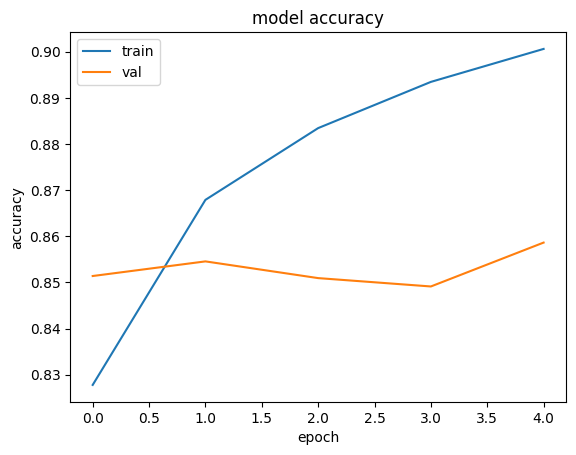

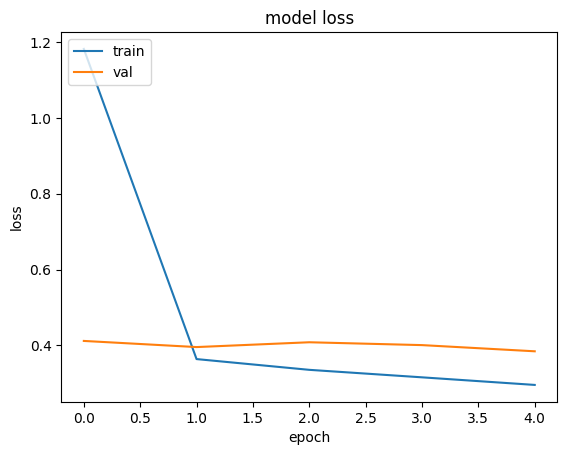

In [34]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

## Test

In [35]:
X_test = test.content.tolist()
y_test = np.array(test.ground)
len(X_test), y_test.shape

(2453, (2453,))

In [36]:
X_test, _, _ = make_padded_docs(X_test,
                            max_length,
                            t)

padded_docs shape: (2453, 256)


In [37]:
y_pred = model.predict(X_test, verbose=1).round()
y_pred

77/77 [==============================] - 3s 27ms/step


array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [0.]], dtype=float32)

In [38]:
target_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.82      0.89      0.85      1198
    positive       0.89      0.81      0.85      1255

    accuracy                           0.85      2453
   macro avg       0.85      0.85      0.85      2453
weighted avg       0.85      0.85      0.85      2453



In [39]:
print('Ground\tPred\tText')
for i in range(10):
    print(str(y_test[i]) + '\t' + str(int(y_pred[i][0])) + '\t' + test.content.tolist()[i])

Ground	Pred	Text
1	1	giao hàng nhanh chóng đóng gói cẩn thận hàng không bị hư hại gì
1	1	được biết shop qua group cháy túi vì shopee thề là e chưa gặp bà nào bán hàng có tâm như bà này phục vụ tận tình nhiệt tình hết chỗ nói giá thì rẻ mà chất lượng thì rất rất ok
0	0	chán thất vọng
1	1	màu sắc nâuquần đẹp rộng rãi mình mua tặng thôi nhưng mà thấy đẹp vậy nên cũng khá ưng ý video mang tính nhận xu nhen
0	0	shop soạn hàng rất ẩu mình đặt lần đầu bị sai màu áo đã bấm trả hàng lần này đặt lại vẫn sai mà sai hết cả món không đúng món nào chất lượng thì ok áo này màu đậm đen hơn minh hoạ nhiều bạn nào chấp nhận việc shop tự phối màu tự chọn size thì mua nè
0	0	vải mỏng nóng
0	0	chất liệu không tốt mấy pha màu
1	1	san pham phu hop gia tien giao hang nhanh dong goi can than se ung ho shop
0	0	shop cheo đầu dê bán thịt chó nhân viên không có trách nhiệm mình gửi áo lại mà mãi không gửi lại tiền mình thật mất khách
1	1	xịn xò lunn mọi người ạ mình mua lần rồi mà ưng quá trời mua tới luôn rồi vả